# YogaPartner

Our datasets are in
- `.\data\v1`
- `.\data\v2`

Our frontend code is in `.\android`

Our generated data goes in `.\intermediates`

In [2]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

version = 2

## Global functions

In [3]:
def getPath():
    return r".\data\v" + str(version)

def getClasses():
    path = getPath()
    return os.listdir(path)

def getPathOfClass(className):
    path = getPath()
    return os.path.join(path, className)

## Dataset stats

In [25]:
def visualizeDataSet():
    classFolders = getClasses()
    counts = []
    imageTypes = {}
    for classFolder in classFolders:
        images = os.listdir(getPathOfClass(classFolder))
        count = len(images)
        counts.append(count)
        for image in images:
            image_path = os.path.join(getPathOfClass(classFolder), image)
            p = Path(image_path)
            ext = p.suffix
            imageTypes[ext] = imageTypes.get(ext, 0) + 1

    print("Dataset frequency distribution")
    for i in range(len(classFolders)):
        className = classFolders[i]
        count = counts[i]
        print(className + " : " + str(count))

    print()

    print("Image type frequency distribution")
    for key in imageTypes.keys():
        count = imageTypes[key]
        print(key + " : " + str(count))

    print()
    
visualizeDataSet()

Dataset frequency distribution
adho_mukha_shvanasana : 437
ardha_matsyendrasana : 96
astavakrasana : 70
bhujangasana : 660
bidalasana : 315
chaturanga_dandasana : 74
garudasana : 66
gomukhasana : 60
phalakasana : 145
ustrasana : 66
utkatasana : 223
utkata_konasana : 210
vasisthasana : 148
virabhadrasana_i : 222
virabhadrasana_ii : 389
vrikshasana : 315

Image type frequency distribution
.jpg : 2485
.png : 966
.jpeg : 45



## Cleaning Data

### Webp to Jpeg

In [16]:
from PIL import Image
import os
import re
from pathlib import Path

classFolders = getClasses()
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        ext = p.suffix
        if ext == ".webp":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jepg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path, "jepg")
            print("Removing " + f)
            os.remove(old_path)
print("Converted Webp")

Converted Webp


### Finding duplicate images

In [6]:
from difPy import dif
import tqdm

classFolders = getClasses()
for className in tqdm.tqdm(classFolders, position=0):
    class_path = getPathOfClass(className)
    search = dif(class_path, delete=True)
print("Completed duplicate image search")

  6%|█████▏                                                                             | 1/16 [00:31<07:52, 31.51s/it]

Found 0 images with one or more duplicate/similar images in 31.5083 seconds.


 12%|██████████▍                                                                        | 2/16 [00:33<03:18, 14.15s/it]

Found 0 images with one or more duplicate/similar images in 1.9941 seconds.


 19%|███████████████▌                                                                   | 3/16 [00:34<01:46,  8.19s/it]

Found 0 images with one or more duplicate/similar images in 1.0993 seconds.
Found 1 image with one or more duplicate/similar images in 70.2026 seconds.
Are you sure you want to delete all lower resolution duplicate images? 
This cannot be undone. (y/n)y


 25%|████████████████████▊                                                              | 4/16 [01:49<06:56, 34.68s/it]


Deleted file: .\data\v2\bhujangasana/98-0.png
***
Deleted 1 images.


 31%|█████████████████████████▉                                                         | 5/16 [02:05<05:06, 27.87s/it]

Found 0 images with one or more duplicate/similar images in 15.778 seconds.


 38%|███████████████████████████████▏                                                   | 6/16 [02:06<03:07, 18.75s/it]

Found 0 images with one or more duplicate/similar images in 1.063 seconds.


 44%|████████████████████████████████████▎                                              | 7/16 [02:07<01:56, 12.91s/it]

Found 0 images with one or more duplicate/similar images in 0.8632 seconds.


 50%|█████████████████████████████████████████▌                                         | 8/16 [02:08<01:12,  9.04s/it]

Found 0 images with one or more duplicate/similar images in 0.7776 seconds.
Found 2 images with one or more duplicate/similar images in 5.6364 seconds.
Are you sure you want to delete all lower resolution duplicate images? 
This cannot be undone. (y/n)y


 56%|██████████████████████████████████████████████▋                                    | 9/16 [02:36<01:44, 14.87s/it]


Deleted file: .\data\v2\phalakasana/00000011.jpg
Deleted file: .\data\v2\phalakasana/00000007.jpg
***
Deleted 2 images.


 62%|███████████████████████████████████████████████████▎                              | 10/16 [02:36<01:03, 10.55s/it]

Found 0 images with one or more duplicate/similar images in 0.8734 seconds.
Found 1 image with one or more duplicate/similar images in 9.67 seconds.
Are you sure you want to delete all lower resolution duplicate images? 
This cannot be undone. (y/n)y


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [03:30<01:57, 23.58s/it]


Deleted file: .\data\v2\utkatasana/5. utkatasana-chair-pose.png
***
Deleted 1 images.


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [03:40<01:17, 19.44s/it]

Found 0 images with one or more duplicate/similar images in 9.9561 seconds.


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [03:45<00:45, 15.15s/it]

Found 0 images with one or more duplicate/similar images in 5.286 seconds.


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [03:54<00:26, 13.39s/it]

Found 0 images with one or more duplicate/similar images in 9.3201 seconds.


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [04:22<00:17, 17.89s/it]

Found 0 images with one or more duplicate/similar images in 28.3113 seconds.


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [04:43<00:00, 17.73s/it]

Found 0 images with one or more duplicate/similar images in 20.6461 seconds.
Completed duplicate image search


### Cleaning up folder names

In [18]:
import os
import re
from pathlib import Path

classFolders = getClasses()
for className in classFolders:
    old_path = getPathOfClass(className)
    new_name = re.sub(r"\s+", "_", className)
    if new_name != className:
        print("Renaming " + className)
    new_path = os.path.join(getPath(), new_name)
    os.rename(old_path, new_path)
print("Renamed class names")

Renamed class names


### Removing non supported images

In [ ]:
from PIL import Image
import os
import re
from pathlib import Path

classFolders = getClasses()
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        f_path = os.path.join(class_path, f)
        if not (f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")):
            os.remove(f_path)
            print("Removed " + f)
print("Finished removing non suporrted images")

### Cleaning up file names

In [11]:
from PIL import Image
import os
import re
from pathlib import Path

classFolders = getClasses()
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        new_file_name = f"{className}_{count}{p.suffix}"
        if new_file_name != f:
            print("Renaming " + f)
        new_file_path = os.path.join(class_path, new_file_name)
        os.rename(old_path, new_file_path)
        count += 1
        
print("Finished cleaning file names")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '.\\data\\v2\\adho_mukha_shvanasana\\adho_mukha_shvanasana_10.jpg' -> '.\\data\\v2\\adho_mukha_shvanasana\\adho_mukha_shvanasana_2.jpg'

## Augmentation

## Pre-process

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

classFolders = getClasses()
filepaths = []
labels = []

for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        fpath = os.path.join(class_path, f)
        filepaths.append(fpath)
        labels.append(className)

Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
trsplit = 0.8
vsplit = 0.1
# split df into train_df and test_df 
dsplit=vsplit/(1-trsplit)
strat=df['labels']    
train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df), ' total length: ', len(filepaths))
print(train_df['labels'].value_counts())

train_df length:  2796   test_df length:  350   valid_df length:  350  total length:  3496
bhujangasana             528
adho_mukha_shvanasana    349
virabhadrasana_ii        311
vrikshasana              252
bidalasana               252
virabhadrasana_i         178
utkatasana               178
utkata_konasana          168
vasisthasana             118
phalakasana              116
ardha_matsyendrasana      77
chaturanga_dandasana      59
astavakrasana             56
garudasana                53
ustrasana                 53
gomukhasana               48
Name: labels, dtype: int64


## Running pre-trained detection model

A:\Projects\CollegeProjects\YogaPartner\data\v2\utkata_konasana\goddess (16).jpg
[[[[0.13067128 0.52368176 0.8875851 ]
   [0.10710134 0.5446176  0.6390412 ]
   [0.10818803 0.49778694 0.8191635 ]
   [0.12723784 0.5709041  0.8636832 ]
   [0.1335147  0.46116188 0.91513723]
   [0.25642705 0.6501862  0.89908695]
   [0.25605375 0.39112163 0.9484251 ]
   [0.3167294  0.82333636 0.9645898 ]
   [0.30256903 0.22984517 0.7475984 ]
   [0.1428221  0.8593171  0.87035644]
   [0.13236271 0.19596462 0.78151107]
   [0.5633948  0.5948806  0.91332954]
   [0.5618038  0.43586466 0.8861468 ]
   [0.665208   0.8161199  0.91313183]
   [0.6673093  0.21950641 0.8618161 ]
   [0.9152539  0.784885   0.8139044 ]
   [0.91227424 0.23293999 0.94533515]]]]
17


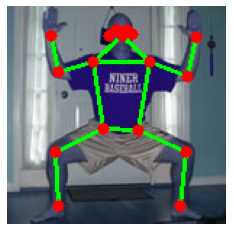

In [25]:
import tensorflow as tf
from matplotlib.collections import LineCollection
import cv2

modelPath = ".\models\movenet_thunder.tflite"
imageSize = 256

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw Keypoints
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape # frame.shape = (480,640,3)
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for kp in shaped:
        ky, kx, k_conf = kp

        if k_conf > confidence_threshold:
            cv2.circle(frame, (round(kx),round(ky)), 4, (255,0,0), -1)


# Draw Connections
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape # frame.shape = (480,640,3)
    shaped = np.squeeze(np.multiply(keypoints,[y,x,1]))

    for edge,color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (round(x1),round(y1)), (round(x2),round(y2)), (0,255,0), 2)
                
def showImagesWithKeypoints(image_path, keypoint_with_scores):
    image = cv2.imread(image_path)
    image = image.copy()
    draw_connections(image, keypoint_with_scores, EDGES, 0.4)
    draw_keypoints(image, keypoints_with_scores, 0.4)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
for i, value in train_df.iterrows():
    image_path = value['filepaths']
    print(image_path)
    image = tf.io.read_file(image_path)
    image = tf.compat.v1.image.decode_jpeg(image)
    image = tf.expand_dims(image, axis=0)
    image = tf.image.resize_with_pad(image, imageSize, imageSize)
    interpreter = tf.lite.Interpreter(model_path=modelPath)
    interpreter.allocate_tensors()
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)
    showImagesWithKeypoints(image_path, keypoints_with_scores)
    break